## ISOMAP

We work on the Swiss Roll data set, which is a good example data set to study nonlinear dimensionality reduction techniques. The data set can be generated using the function make swiss roll from scikit-learn.

### a) Generating a swiss roll data set

Generate a swiss roll data set of 800 points using the random seed 1234. Produce a 3D scatter plot of the swiss roll. Data points that are next to each other should have a similar color.

In [1]:
import numpy as np
import math
import scipy as sp
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline


Text(0.5,0,'x3')

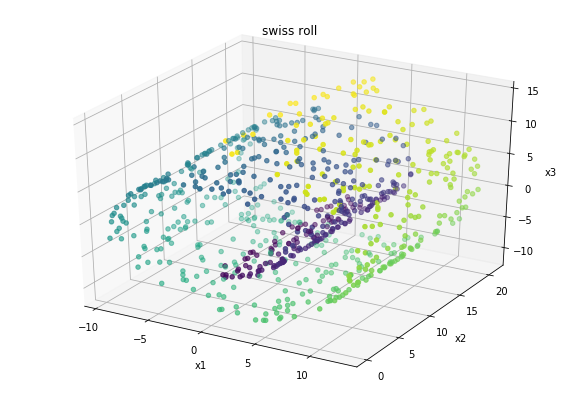

In [2]:
# swiss roll (X is a n x D matrix!)
X,t = datasets.make_swiss_roll(n_samples = 800, random_state = 1234)

# plot swiss roll
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
plt.title('swiss roll')

ax.scatter(X[:,0], X[:,1], X[:,2], c=t)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')


### b) PCA on swiss roll

Perform a PCA of the swiss roll data. Show and explain briefly the scatter plot for the first two principal components.

In [3]:
def my_pca(X, d):
    D, n = np.shape(X)
    
    # sample covariance matrix
    sample_cov = 1/n * X@X.T
    
    # EVD
    Lambda, V = np.linalg.eigh(sample_cov)

    # picking the d largest eigenvalues and corresponding eigenvectors
    indices = np.arange(D-d, D, 1)
    Lambda_d = Lambda[indices]
    V_d = V[:,indices]
    
    Z = V_d.T @ X
    
    Z_w = np.linalg.inv(np.diag(np.sqrt(Lambda_d))) @ Z   # whitening
    return(Z, Z_w)


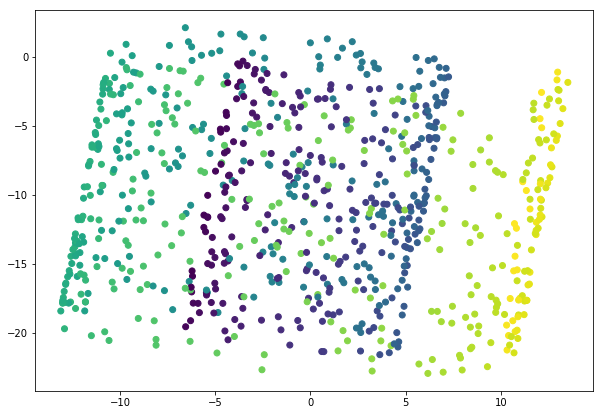

In [4]:
X2, X2_w = my_pca(X.T,2)

plt.figure(figsize=(10,7))
plt.scatter(X2[0], X2[1], c=t)


PCA assumes a linear correlation.  
The swiss roll is nonlinear.   
$\Rightarrow $ PCA doesn't give the desired result   
What we see is basically a projection of the swiss roll on the x2-x3-plane. Therefore the classes are still not separable

### c) General idea

What is the general idea behind ISOMAP?

ISOMAP captures the local distances on the manifold and finds a low dimensional embedding of the manifold where those (local) distances are unchanged. To do this, ISOMAP constructs a neighborhood graph and computes the all-pairs-shortest paths along the graph. Then those distances are transformed through multi-dimensional scaling into the desired embedding.

### d) Implement ISOMAP

Implement ISOMAP only using basic Python/NumPy/SciPy functions. Use a k near- est neighbor graph and an ε graph to model the neighborhood relationship between the data points.

In [5]:
def distances(X):
    (D,n) = np.shape(X)
    D = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            D[i,j] = np.linalg.norm(X[:,i]-X[:,j]) 
    return(D)


In [7]:
def knn(D,k):
    (n,n) = np.shape(D)
    W = float('inf') * np.ones((n,n))
    for i in range(n): 
        index = np.argpartition(D[i], k+1) # gives an array where the first k+1 entrys are the indices 
                                           # of the k+1 smallest values in D[i] 
        for j in range(k+1):
            W[i,index[j]] = D[i,index[j]]  # k+1 because D[i,j] = 0 for i=j 
    W = (W+W.T)/2
    return(W)


In [8]:
def epsilon(D, epsilon):
    (n,n) = np.shape(D)
    W = float('inf') * np.ones((n,n))
    for i in range(n):
        for j in range(n):
            if(i == j):
                W[i,i] = 0
            else: 
                if(D[i,j] < epsilon):
                    W[i,j] = D[i,j]                
    return(W)


In [9]:
def apspFW(W):
    D = W
    (n,n) = np.shape(W)
    count = 1
    for k in range(n):
        for i in range(n):
            for j in range(n):
                D[i,j] = np.minimum(D[i,j], D[i,k]+D[k,j])
    return(D)


In [10]:
def mds(D):
    (n,n) = np.shape(D)
    
    D = D * D # squared distances
    
    H = np.eye(n) - np.ones((n,n))/n # centering matrix
    
    G = -0.5 * (H @ D @ H) # Gram matrix
    
    (Lambda, V) = np.linalg.eigh(G)  # EVD of Gram matrix (with ordered eigenvalues)
    
    Lambda2 = Lambda[[n-1,n-2]]
    V2 = V[:,[n-1,n-2]]
    
    Z = np.diag(np.sqrt(Lambda2.T)) @ V2.T  # data matrix
    
    return(Z)
    

In [11]:
def isomap(X, neighbor = 'knn', par = 10):
    # neighbor: 'knn'       for k nearest neighbor graph  => par = k
    #           'epsilon'   for epsilon graph             => par = epsilon
    
    # construct neighborhood graph
    D = distances(X)  
    
    if(neighbor == 'epsilon'):
        W = epsilon(D, par) 
    else:
        W = knn(D, par)
    
    # compute all-pairs-shortest paths along the graph
    
    # D_graph = apspFW(W) is too slow
    D_graph = sp.sparse.csgraph.floyd_warshall(W, directed = False)
    
    # multi-dimensional scaling
    Z = mds(D_graph)
    return(Z)


### e)

Try to find good values for k and ε. What might go wrong when you choose inap- propriate values?

If the values are too small:   
 The points might have no neighbors at all or at least not enough to create a meaningful embedding (not enough information about the distances).  
If the values are too big:  
 The points have too many neighbors. In this example violet points might be neighbors of yellow points. This would cause them to be neighbors, i.e. be close to one another, in the resulting embedding. Such an embedding would still have some kind of undesired spiral structure.

For this exercise $k = 12$ and $\epsilon = 5$ seem to be good values.  

### f)

Reduce the number of dimensions of the swiss roll from three to two. Visualize your results using a colored scatter plot. Do you see any improvement over PCA?

(3, 800)


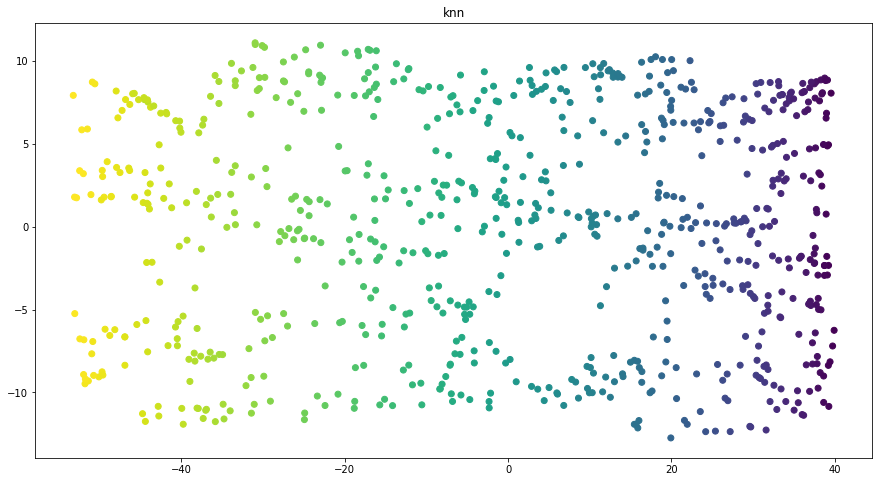

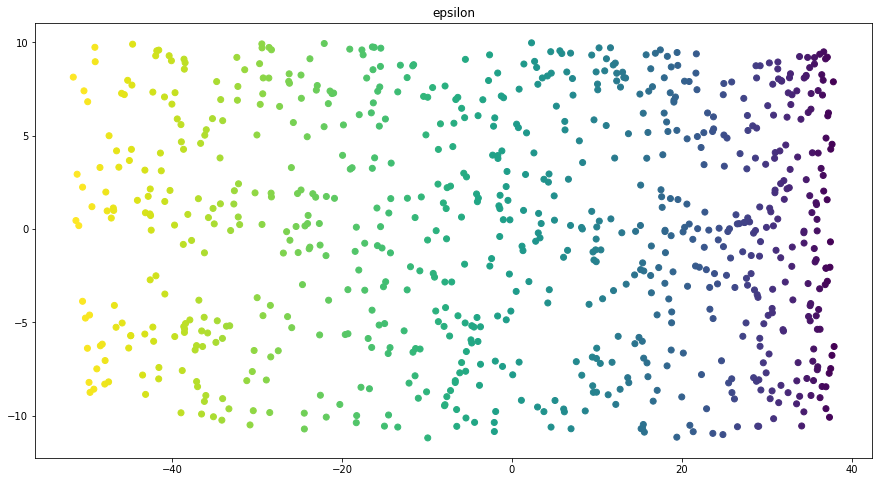

In [ ]:
print(np.shape(X.T))
Z = isomap(X.T, neighbor = 'knn', par = 12)
plt.figure(figsize=(15,8))
plt.title('knn')
plt.scatter(Z[0], Z[1],c=t)

Z = isomap(X.T, neighbor = 'epsilon', par = 5)
plt.figure(figsize=(15,8))
plt.title('epsilon')
plt.scatter(Z[0], Z[1],c=t)


The ISOMAP embedding is the desired unrolled manifold. In contrast to the PCA result it captures just the distances on the manifold. A much more complex structure in three dimensions got transformed into a simple two-dimensional structure.